In [1]:
using PyCall
include("../src/gauss_error.jl")
include("../src/kernels.jl")
include("../src/mcmc.jl")

a = 0
b = 6.

function phi(x::Real)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5
    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

myplot = plot(x, phi.(x))

MethodError: MethodError: no method matching plot(::Array{Float64,1}, ::Array{Float64,1})
Closest candidates are:
  plot(::Any, !Matched::Union{Array{Layer,1}, Function, Element, Theme, Type}...; mapping...) at /Users/ta_nyan/.julia/packages/Gadfly/09PWZ/src/Gadfly.jl:287
  plot(::Any, !Matched::Dict, !Matched::Union{Array{Layer,1}, Function, Element, Theme, Type}...) at /Users/ta_nyan/.julia/packages/Gadfly/09PWZ/src/Gadfly.jl:321

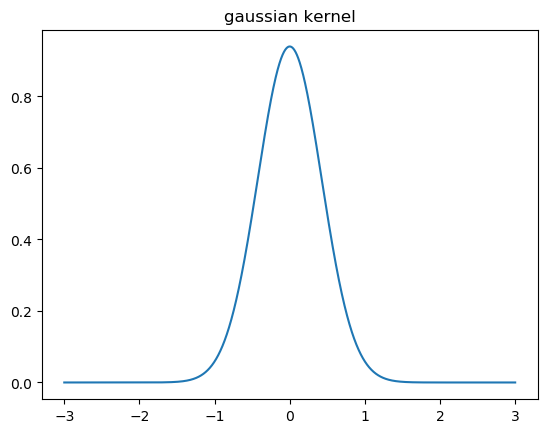

PyObject Text(0.5, 1.0, 'gaussian kernel')

In [2]:
# kernel_name = "rectangular"
# kernel_name = "diffraction"
kernel_name = "gaussian"
# kernel_name = "triangular"
# kernel_name = "dispersive"
# kernel_name = "exponential"
# kernel_name = "heaviside"


kernel(x::Real, y::Real) = getOpticsKernels(kernel_name)(x, y)

using PyPlot
q = collect(range(-3, stop=3, length=3000))
ker_res = [kernel(q_, 0.) for q_ in q]
plot(q, ker_res)
title(string(kernel_name, " kernel"))
# savefig(string(kernel_name, "kernel.png"))

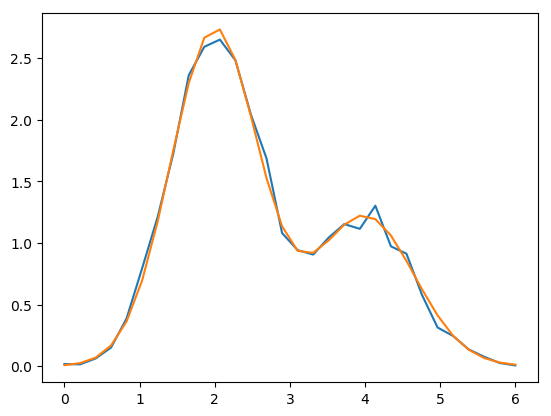

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)
sig = 0.05*ftrue + [0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

f = ftrue + noise
plot(y, f)
plot(y, ftrue)
println()

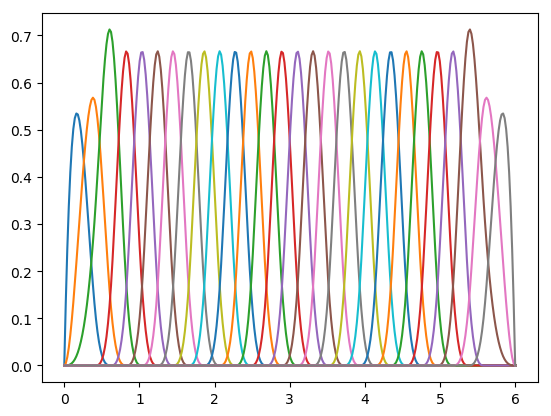

┌ Info: Cubic spline basis is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:235


In [4]:
using PyPlot
knots = y
basis = CubicSplineBasis(knots, "dirichlet")

for func in basis.basis_functions
    plot(x, func.f.(x))
end

In [5]:
# using PyPlot

Omega = omega(basis, 2)
# matshow(Omega)
# colorbar()
# # title("Omega matrix for Cubic Spline basis with 30 basis functions")
# savefig("omega_legendre_10.png")
print()

┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:249
┌ Info: Omega caclulated successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:265


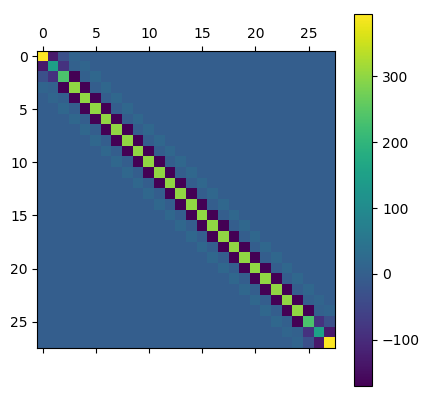

PyObject <matplotlib.colorbar.Colorbar object at 0x18ad221d0>

In [6]:
matshow(Omega)
colorbar()

In [7]:
model = GaussErrorUnfolder(basis, [Omega], "EmpiricalBayes", nothing, [1e-8], [10.], [0.3])
println()

┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:65
┌ Info: GaussErrorUnfolder is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:169


In [8]:
phi_reconstruct = solve(model, kernel, f, sig, y)

┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:202
┌ Info: Starting discretize kernel...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:46
┌ Info: Kernel was discretized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:57
┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:95
┌ Info: Starting find_optimal_alpha...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:122
┌ Info: Starting optimization...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:147


Iter     Function value   Gradient norm 
     0    -4.524371e+02     8.802960e+00
     1    -4.586930e+02     1.861424e+00
     2    -4.591032e+02     5.347496e-02
     3    -4.591035e+02     3.776956e-06
     4    -4.591035e+02     2.336606e-08
     5    -4.591035e+02     2.336606e-08


┌ Info: Optimized successfully, alphas = [0.0600728].
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:162
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:113
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/gauss_error.jl:210


Dict{String,Array{Float64,N} where N} with 3 entries:
  "errors" => [0.0402273 0.0134331 … 1.31516e-7 -2.96476e-6; 0.0134331 0.079445…
  "alphas" => [0.0600728]
  "coeff"  => [-0.0324558, -0.12403, -0.146489, 0.0313295, 0.471783, 1.1492, 1.…

In [9]:
phivec = PhiVec(phi_reconstruct["coeff"], basis, phi_reconstruct["errors"])
println()

┌ Info: PhiVec is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:69


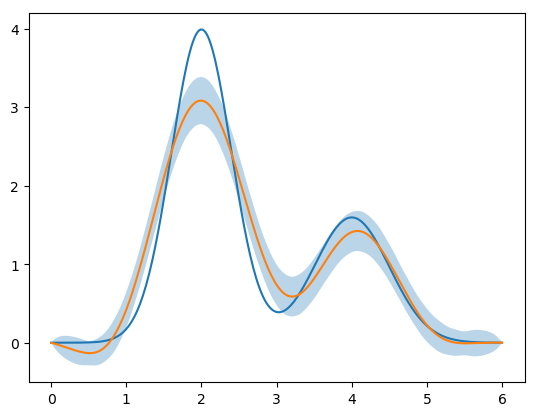

PyObject <matplotlib.collections.PolyCollection object at 0x19e02dd68>

In [10]:
using PyPlot

plot(x, phi.(x))
phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)
println()

plot(x, phi_reconstructed)
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)

In [11]:
model_mcmc = MCMCUnfolder(basis, [Omega], "EmpiricalBayes", nothing, [1e-5], [10.], [0.5])
println()

┌ Info: MCMCMatrixUnfolder is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:65
┌ Info: MCMCUnfolder is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:236


In [12]:
model_, line, inits, samples, burnin, thin, chains = solve(model_mcmc, discretize_kernel(basis, kernel, y), f, sig, nothing, 1, 10000)
sim = mcmc(model_, line, inits, samples, burnin=burnin, thin=thin, chains=chains)
res = get_values(sim, chains, length(basis))
println()

┌ Info: Starting discretize kernel...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:46
┌ Info: Kernel was discretized successfully.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/basis.jl:57


Iter     Function value   Gradient norm 
     0    -4.471545e+02     1.180497e+01
     1    -4.564415e+02     4.444390e+00
     2    -4.591034e+02     2.777588e-02
     3    -4.591035e+02     3.099341e-06
     4    -4.591035e+02     5.007014e-08
     5    -4.591035e+02     1.669005e-09


┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:275
┌ Info: Starting solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:104
┌ Info: Starting find_optimal_alpha...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:122
┌ Info: Starting optimization...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:147
┌ Info: Optimized successfully, alphas = [0.0600728].
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/check.jl:162
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:120
┌ Info: Starting solve_MCMC...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:132
┌ Info: Ending solve_MCMC...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:155
┌ Info: Ending solve...
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/mcmc.jl:284


MCMC Simulation of 10000 Iterations x 1 Chain...

Chain 1:   0% [0:19:52 of 0:19:53 remaining]
Chain 1:  10% [0:01:08 of 0:01:16 remaining]
Chain 1:  20% [0:00:57 of 0:01:11 remaining]
Chain 1:  30% [0:00:48 of 0:01:09 remaining]
Chain 1:  40% [0:00:40 of 0:01:07 remaining]
Chain 1:  50% [0:00:34 of 0:01:08 remaining]
Chain 1:  60% [0:00:27 of 0:01:08 remaining]
Chain 1:  70% [0:00:20 of 0:01:07 remaining]
Chain 1:  80% [0:00:13 of 0:01:06 remaining]
Chain 1:  90% [0:00:07 of 0:01:05 remaining]
Chain 1: 100% [0:00:00 of 0:01:05 remaining]




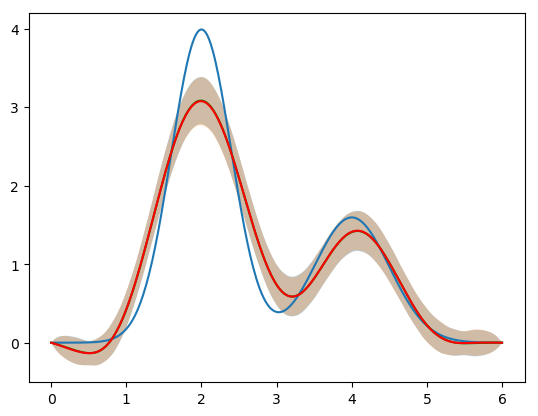

┌ Info: PhiVec is created.
└ @ Main /Users/ta_nyan/Documents/diploma/StatReg.jl/src/vector.jl:69


PyObject <matplotlib.collections.PolyCollection object at 0x19f4a2208>

In [13]:
phivec_mcmc = PhiVec(res, basis)
phi_reconstructed_mcmc = phivec_mcmc.phi_function.(x)
phi_reconstructed_mcmc_errors = phivec_mcmc.error_function.(x)
# title("MCMC integration")
plot(x, phi.(x))
plot(x, phi_reconstructed, "g")
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)
plot(x, phi_reconstructed_mcmc, "r")
fill_between(x, phi_reconstructed_mcmc - phi_reconstructed_mcmc_errors, phi_reconstructed_mcmc + phi_reconstructed_mcmc_errors, alpha=0.3)
# savefig("mcmc.png")
# title("phi(x)")
# savefig("phi_function.png")